In [1]:
import os
import sys
import re
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../scrnaseq-wf/data/scrnaseq_combine_force')

last updated: 2018-08-22 
Git hash: b8389b62d61f5da9d0f1dbc553341dae7e776080


In [3]:
raw = pd.read_parquet('../scrnaseq-wf/data/raw_by_cluster.parquet')
zscore = pd.read_parquet('../scrnaseq-wf/data/tpm_zscore.parquet')

## Silhouette Analysis to identify *K*

In [154]:
X = zscore.values
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 128, 256, 512, 1024]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_jobs=-2)
    cluster_labels = clusterer.fit_predict(X)

    # Compute average score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.371348987463
For n_clusters = 3 The average silhouette_score is : 0.344279630096
For n_clusters = 4 The average silhouette_score is : 0.353772397279
For n_clusters = 5 The average silhouette_score is : 0.285707676567
For n_clusters = 6 The average silhouette_score is : 0.28567141032
For n_clusters = 7 The average silhouette_score is : 0.281741212404
For n_clusters = 8 The average silhouette_score is : 0.251052050717
For n_clusters = 16 The average silhouette_score is : 0.250923984486
For n_clusters = 32 The average silhouette_score is : 0.173589808135
For n_clusters = 64 The average silhouette_score is : 0.147361280915
For n_clusters = 128 The average silhouette_score is : 0.132876303479
For n_clusters = 256 The average silhouette_score is : 0.122226504887
For n_clusters = 512 The average silhouette_score is : 0.12009805322
For n_clusters = 1024 The average silhouette_score is : 0.121529254518


,Avg. Silhouette Score
Number of Clusters,
2,0.371357
3,0.344280
4,0.353772
5,0.285685
6,0.285715
7,0.281804
8,0.252109
9,0.244460
10,0.247762


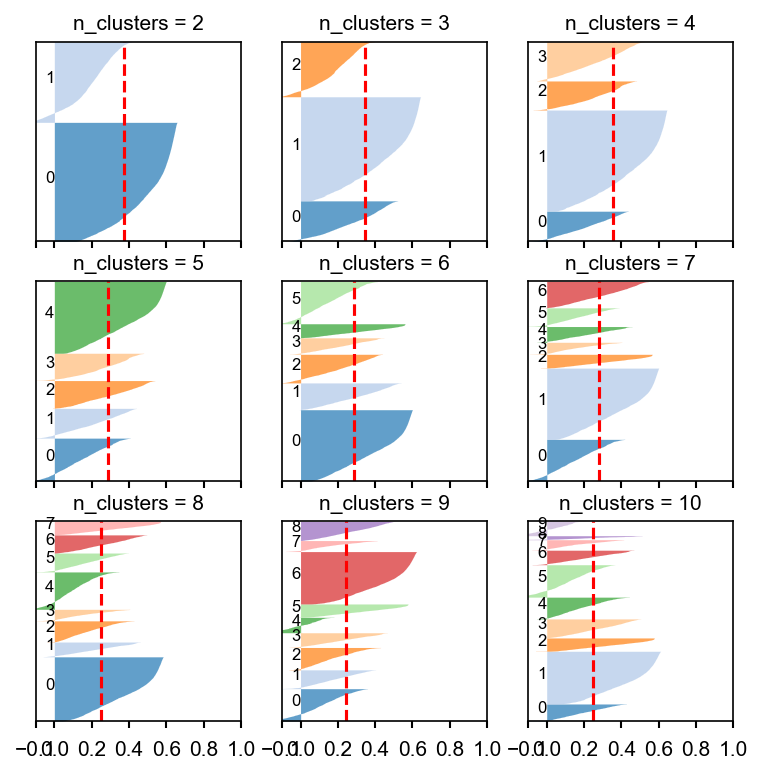

In [18]:
X = zscore.values
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
scores = []
fig, axes = plt.subplots(3, 3, sharex=True)
for ax, n_clusters in zip(axes.flatten(), range_n_clusters):
    colors = sns.color_palette('tab20', n_colors=n_clusters)
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Compute average score
    silhouette_avg = silhouette_score(X, cluster_labels)
    scores.append((n_clusters, silhouette_avg))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=8)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(f'n_clusters = {n_clusters}', fontsize=10)

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

df = pd.DataFrame(scores, columns=['Number of Clusters', 'Avg. Silhouette Score']).set_index('Number of Clusters')
display(df)

## Run KMeans

Silhouette analysis was not super useful. Average scores were very low for everything except K=2. I iterated here a few times and think k of 10 has pretty good separation.

cluster 1: 1095 genes
cluster 2: 665 genes
cluster 3: 687 genes
cluster 4: 1390 genes
cluster 5: 2344 genes
cluster 6: 858 genes
cluster 7: 1601 genes
cluster 8: 1289 genes
cluster 9: 760 genes
cluster 10: 3787 genes


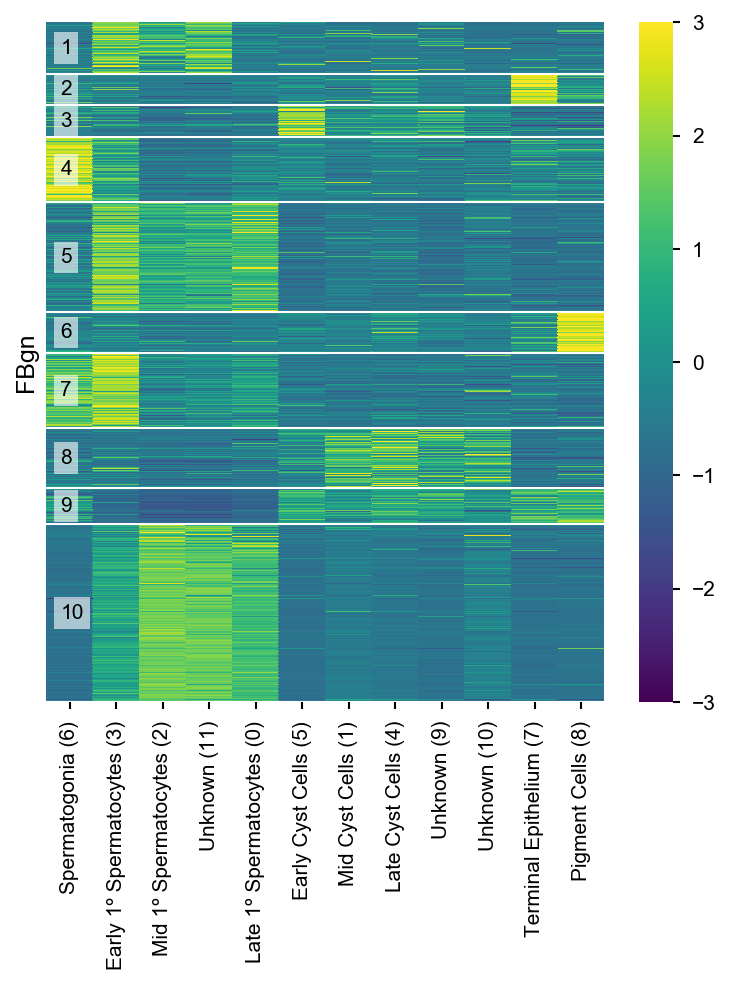

In [14]:
X = zscore.values
km = KMeans(n_clusters=10, n_jobs=-2, random_state=42)
km.fit(X)

_dat = zscore.assign(km=km.labels_ + 1).sort_values('km')

ax = sns.heatmap(_dat.drop('km', axis=1), yticklabels=False, cmap='viridis', vmin=-3, vmax=3)

loc = 0
for g, dd in _dat.groupby('km'):
    print(f'cluster {g}: {dd.shape[0]} genes')
    loc += dd.shape[0]
    ax.axhline(loc, color='w', lw=1)
    ax.text(0.3, loc - (dd.shape[0] / 2), g, va='center', ha='left', fontsize=10, color='k', bbox=dict(color='w', alpha=.6, ec='none', boxstyle='square,pad=.3'))

Where are the genes that I call out in the other panels?

In [19]:
# Genes called out in other panels of fig1
goi = ['vas', 'bam', 'aly', 'nht', 'soti', 'dj', 'ocn', 'tj', 'eya', 'nord', 'bw', 'SRPK', 'bol', 'Piezo', 'osa', 'mbl', 'ADD1']
foi = [nbconfig.symbol2fbgn[x] for x in goi]

gene_kmean = pd.concat([_dat.loc[foi, 'km'], pd.Series(nbconfig.fbgn2symbol)], axis=1, sort=True).dropna()
gene_kmean.columns = ['KMeans', 'gene_symbol']
gene_kmean = gene_kmean[['gene_symbol', 'KMeans']].sort_values(by='KMeans')
gene_kmean.KMeans = gene_kmean.KMeans.astype(int)

gene_kmean

,gene_symbol,KMeans
FBgn0264953,Piezo,2
FBgn0050418,nord,2
FBgn0265487,mbl,2
FBgn0000964,tj,3
FBgn0000158,bam,4
FBgn0261885,osa,4
FBgn0283442,vas,4
FBgn0000241,bw,6
FBgn0026370,SRPK,7
FBgn0041103,nht,7


## What about hierarchical clustering?

I still think hierarchical clustering gives a better picture of the data, but determining cut points is difficult. KMeans is easier to say these genes are in this group of genes. Now I will try to go ahead and ID the location of the genes of interest in the hierarchy.

In [21]:
link = linkage(zscore, 'average')
tree = dendrogram(link, no_plot=True)
leaves = tree['leaves']

In [38]:
_dat = zscore.iloc[leaves, :]

In [39]:
fb2sym = pd.Series(nbconfig.fbgn2symbol, name='gene_symbol')
fb2sym.index.name = 'FBgn'

In [52]:
locs = fb2sym.reindex(_dat.index).to_frame().reset_index().gene_symbol

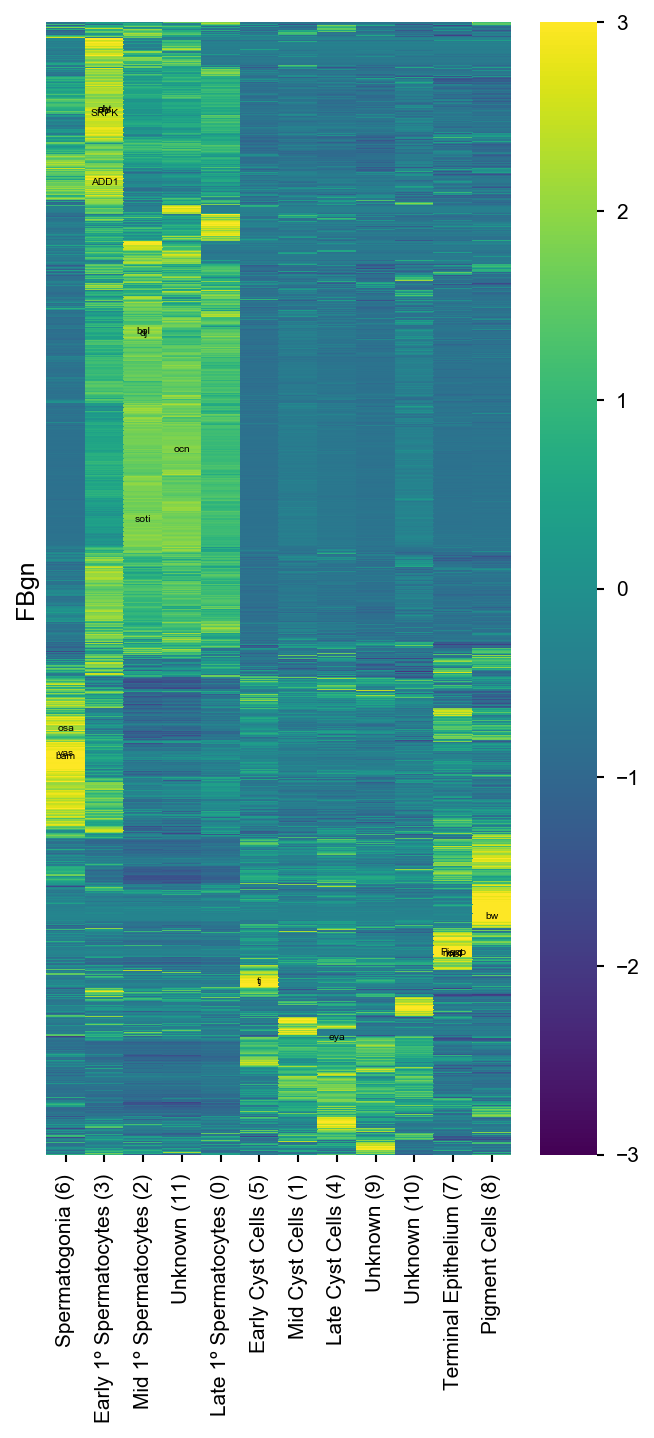

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
sns.heatmap(_dat, yticklabels=False, cmap='viridis', vmin=-3, vmax=3, ax=ax)

for gene in goi:
    loc = locs.index[locs == gene].values[0]
    x = _dat.iloc[loc, :].values.argmax() + .5
    ax.text(x, loc, gene, fontsize=5, va='center', ha='center')